```
Data Structure:
cycle:	top level structure array containing the charge, discharge and impedance operations
	type: 	operation  type, can be charge, discharge or impedance
	ambient_temperature:	ambient temperature (degree C)
	time: 	the date and time of the start of the cycle, in MATLAB  date vector format
	
    data:	data structure containing the measurements
    
	   for charge the fields are:
                Voltage_measured: 	    Battery terminal voltage (Volts)
                Current_measured:	    Battery output current (Amps)
                Temperature_measured: 	Battery temperature (degree C)
                Current_charge:		    Current measured at charger (Amps)
                Voltage_charge:		    Voltage measured at charger (Volts)
                Time:			        Time vector for the cycle (secs)
                
	   for discharge the fields are:
                Voltage_measured: 	    Battery terminal voltage (Volts)
                Current_measured:	    Battery output current (Amps)
                Temperature_measured: 	Battery temperature (degree C)
                Current_load:		    Current measured at load (Amps)
                Voltage_load:		    Voltage measured at load (Volts)
                Time:			        Time vector for the cycle (secs)
                Capacity:		        Battery capacity (Ahr) for discharge till 2.7V 
                
	   for impedance the fields are:
                Sense_current:		    Current in sense branch (Amps)
                Battery_current:	    Current in battery branch (Amps)
                Current_ratio:		    Ratio of the above currents 
                Battery_impedance:	    Battery impedance (Ohms) computed from raw data
                Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms) 
                Re:			            Estimated electrolyte resistance (Ohms)
                Rct:			        Estimated charge transfer resistance (Ohms)
```

In [3]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

In [4]:
bs = [
    'B0005',
    'B0006',
    'B0007',
    'B0018'
]

ds = []
for b in bs:
    ds.append(loadmat(f'DATA/{b}.mat'))

In [5]:
types = []
times = []
ambient_temperatures = []
datas = []

for i in range(len(ds)):
    x = ds[i][bs[i]]["cycle"][0][0][0]
    ambient_temperatures.append(x['ambient_temperature'])
    types.append(x['type'])
    times.append(x['time'])
    datas.append(x['data'])

In [6]:
for i in range(len(ds)):
    print(f'Battery: {bs[i]}')
    print(f'Cycles: {datas[i].size}')
    print()

Battery: B0005
Cycles: 616

Battery: B0006
Cycles: 616

Battery: B0007
Cycles: 616

Battery: B0018
Cycles: 319



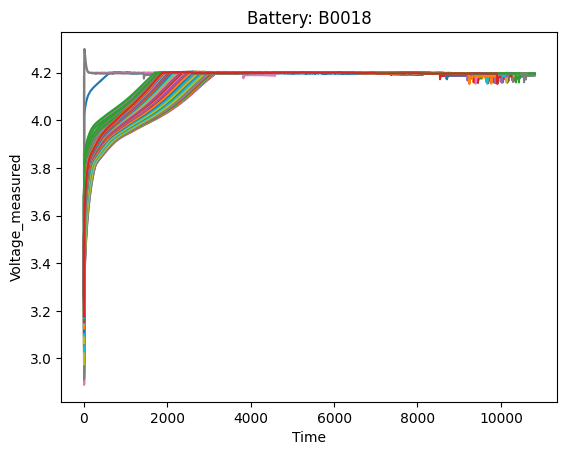

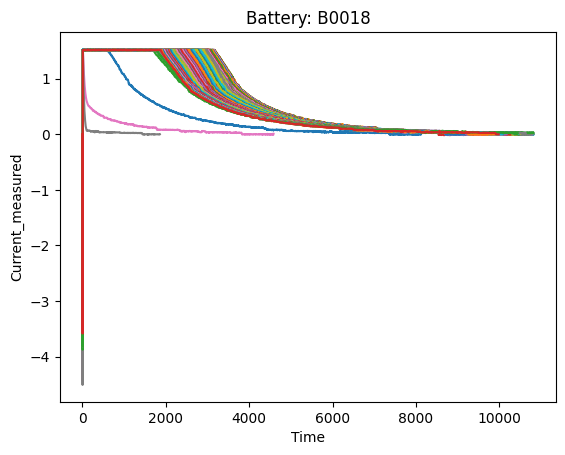

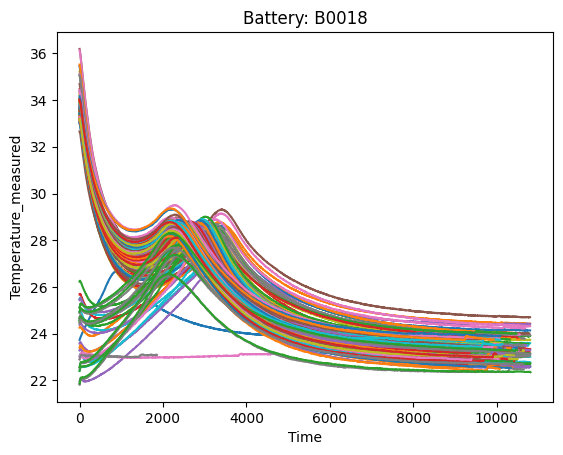

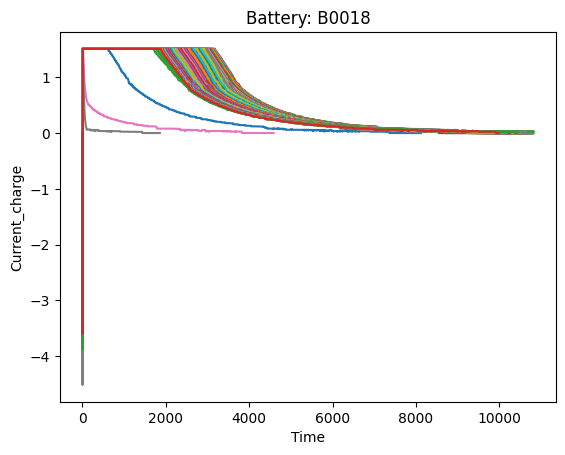

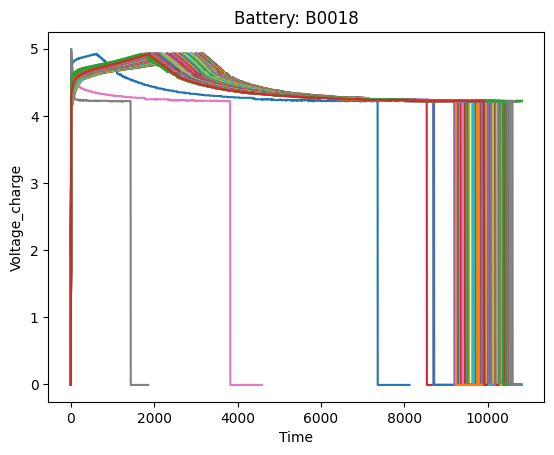

In [7]:
params = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_charge', 'Voltage_charge']
battery_index = 3

for param in params:
    fig, ax = plt.subplots(1, 1)  # Single plot for the specified battery index

    for j in range(datas[battery_index].size):
        if types[battery_index][j] == 'charge':
            ax.plot(datas[battery_index][j]['Time'][0][0][0], datas[battery_index][j][param][0][0][0])
            ax.set_title(f'Battery: {bs[battery_index]}')

    ax.set(ylabel=param, xlabel='Time')
    plt.show()


## Charge First and Last Cycles

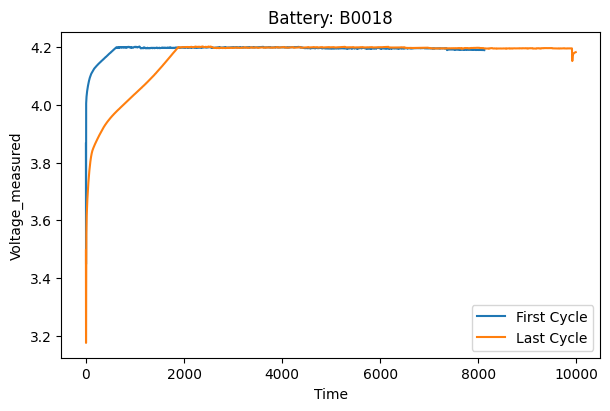

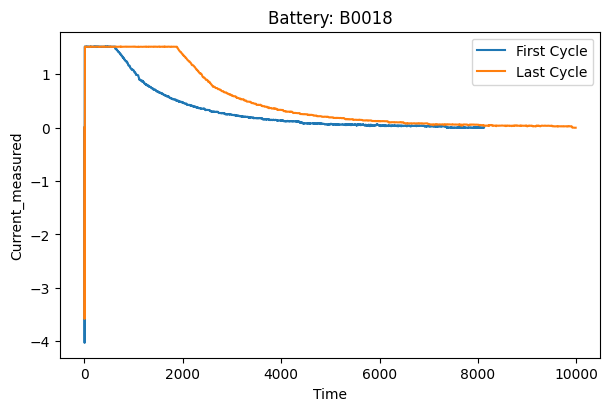

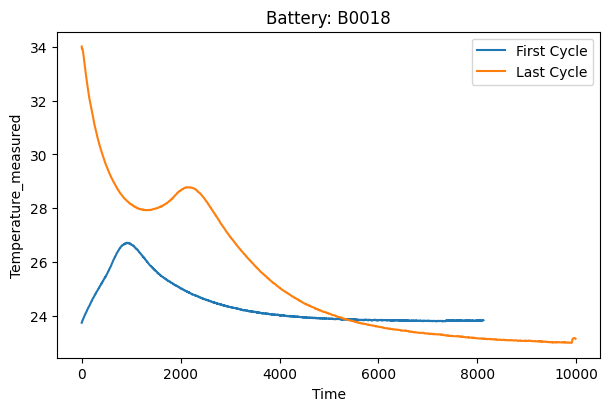

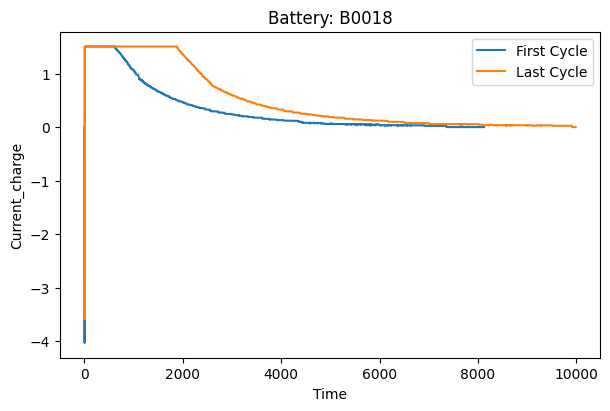

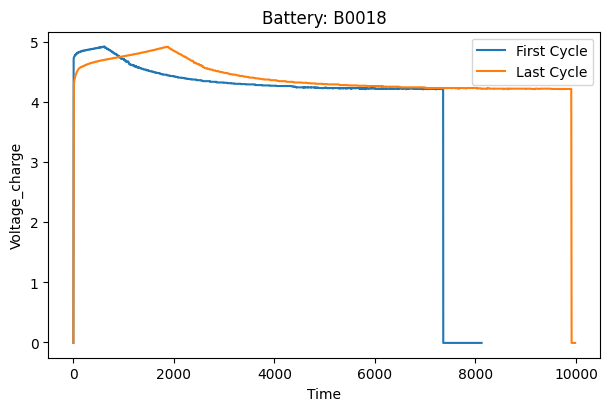

In [8]:
for param in params:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))  # Single plot for the specified parameter

    # Plotting the first cycle
    first_cycle_index = 0
    if types[battery_index][first_cycle_index] == 'charge':
        ax.plot(datas[battery_index][first_cycle_index]['Time'][0][0][0], datas[battery_index][first_cycle_index][param][0][0][0], label='First Cycle')
    
    # Plotting the last cycle
    last_cycle_index = datas[battery_index].size -2
    if types[battery_index][last_cycle_index] == 'charge':
        ax.plot(datas[battery_index][last_cycle_index]['Time'][0][0][0], datas[battery_index][last_cycle_index][param][0][0][0], label='Last Cycle')

    # Set titles and labels
    ax.set_title(f'Battery: {bs[battery_index]}')
    ax.set(ylabel=param, xlabel='Time')
    ax.legend()

    fig.tight_layout(pad=0.3)
    plt.show()


## Discharge First and Last Cycles

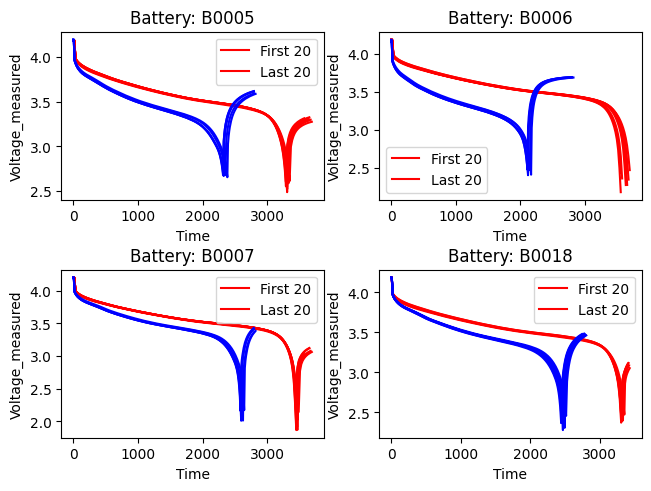

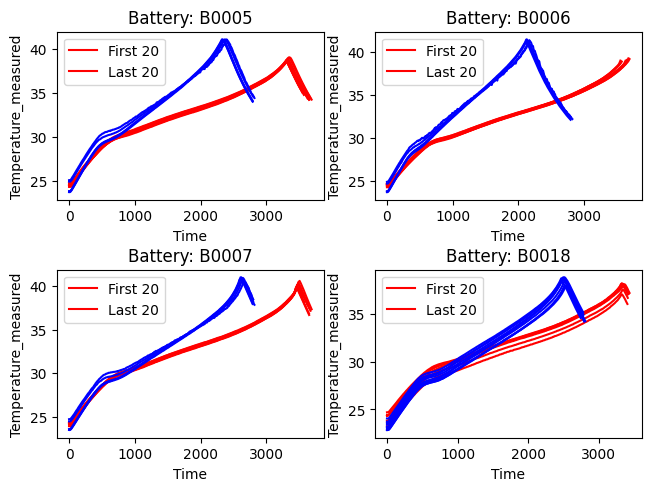

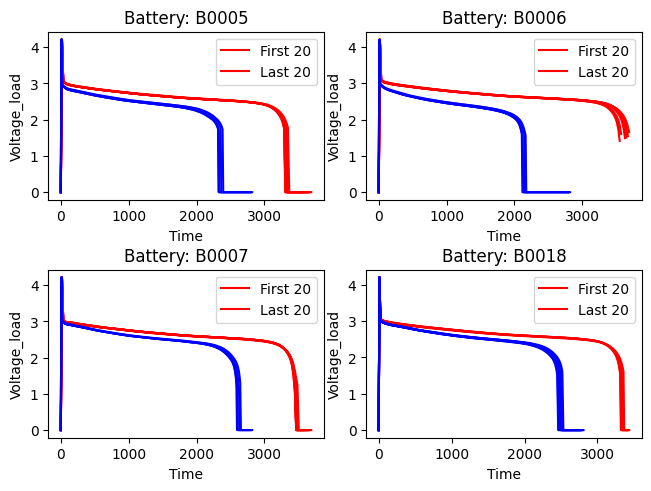

In [9]:
params = ['Voltage_measured', 'Temperature_measured', 'Voltage_load']
for p in params:

    # Printing first 20 cycles
    fig, axs = plt.subplots((len(bs) + 1) // 2, 2)
    param = p
    for i in range(len(bs)):
        for j in range(20):
            if types[i][j] == 'discharge':
                if i % 2 == 0:
                    axs[i // 2, 0].plot(datas[i][j]['Time'][0][0][0], datas[i][j][param][0][0][0], '-r')
                    axs[i // 2, 0].set_title(f'Battery: {bs[i]}')
                else:
                    axs[i // 2, 1].plot(datas[i][j]['Time'][0][0][0], datas[i][j][param][0][0][0], '-r')
                    axs[i // 2, 1].set_title(f'Battery: {bs[i]}')
    for i in range(len(bs)):
        for j in range(datas[i].size - 20, datas[i].size):
            if types[i][j] == 'discharge':
                if i % 2 == 0:
                    axs[i // 2, 0].plot(datas[i][j]['Time'][0][0][0], datas[i][j][param][0][0][0], '-b')
                    axs[i // 2, 0].set_title(f'Battery: {bs[i]}')
                else:
                    axs[i // 2, 1].plot(datas[i][j]['Time'][0][0][0], datas[i][j][param][0][0][0], '-b')
                    axs[i // 2, 1].set_title(f'Battery: {bs[i]}')

    for ax in axs.flat:
        ax.set(ylabel = param, xlabel = 'Time')
        ax.legend(['First 20', 'Last 20'])
        leg = ax.get_legend()
    fig.tight_layout(pad = 0.3)

## Regression 
- From the above analysis the data seems to be very linear thus Regression is a good model to start with.
- Discharge Cycles are used for training and testing the model.

In [10]:
Cycles = {}
params = ['Temperature_measured', 'Voltage_measured', 'Voltage_load', 'Time']

for i in range(len(bs)):
    Cycles[bs[i]] = {}
    Cycles[bs[i]]['count'] = 168 # This is true for battery B0005, 06, 07
    for param in params:
        Cycles[bs[i]][param] = []
        for j in range(datas[i].size):
            if types[i][j] == 'discharge':
                Cycles[bs[i]][param].append(datas[i][j][param][0][0][0])
        
    cap = []
    for j in range(datas[i].size):
        if types[i][j] == 'discharge':
            cap.append(datas[i][j]['Capacity'][0][0][0][0])
    Cycles[bs[i]]['Capacity'] = np.array(cap)

# Features Extraction

- In the given dataset every cycle is represented by set of arrays.
- Out of which Temperature, VoltageMeasured, VoltageLoad seems to best describe the cycle
- These values are measured at different time points which are represented in Time array
- Rather than using entire array for training we can extract **critical time points for each of the features** and train the model on these **critical time points**
- Only using these **critical points** will reduce the training time and reduce the noise in data

## Critical Points for a given cycle
**TEMPERATURE_MEASURED**
- Time at highest temperature
  
  
**VOLTAGE_MEASURED**
- Time at lowest Voltage
  
**VOLTAGE_LOAD**
- First time it drops below 1 volt after 1500 seconds

In [11]:
def getTemperatureMeasuredCritical(tm, time):
    high = 0
    critical = 0
    for i in range(len(tm)):
        if (tm[i] > high):
            high = tm[i]
            critical = time[i]
    return critical

def getVoltageMeasuredCritical(vm, time):
    low = 1e9
    critical = 0
    for i in range(len(vm)):
        if (vm[i] < low):
            low = vm[i]
            critical = time[i]
    return critical

def getVoltageLoadCritical(vl, time):
    for i in range(len(vl)):
        if (time[i] > 1500 and vl[i] < 1):
            return time[i]
    return -1

In [12]:
# First Cycle
f = getTemperatureMeasuredCritical(Cycles[bs[0]]['Temperature_measured'][0], Cycles[bs[0]]['Time'][0])

# 100th Cycle
m = getTemperatureMeasuredCritical(Cycles[bs[0]]['Temperature_measured'][100], Cycles[bs[0]]['Time'][100])

# Last Cycle
l = getTemperatureMeasuredCritical(Cycles[bs[0]]['Temperature_measured'][167], Cycles[bs[0]]['Time'][167])

print(f'Temperature_Measured Critical points')
print(f'First Cycle:\t{f}')
print(f'100th Cycle:\t{m}')
print(f'Last Cycle:\t{l}')

## Conclusion - BATTERIES GET HOT QUICKER as they AGE!!

Temperature_Measured Critical points
First Cycle:	3366.781
100th Cycle:	2682.156
Last Cycle:	2393.578


In [13]:
# First Cycle
f = getVoltageMeasuredCritical(Cycles[bs[0]]['Voltage_measured'][0], Cycles[bs[0]]['Time'][0])

# 100th Cycle
m = getVoltageMeasuredCritical(Cycles[bs[0]]['Voltage_measured'][100], Cycles[bs[0]]['Time'][100])

# Last Cycle
l = getVoltageMeasuredCritical(Cycles[bs[0]]['Voltage_measured'][167], Cycles[bs[0]]['Time'][167])

print(f'Voltage_measured Critical points')
print(f'First Cycle:\t{f}')
print(f'100th Cycle:\t{m}')
print(f'Last Cycle:\t{l}')

Voltage_measured Critical points
First Cycle:	3346.937
100th Cycle:	2662.828
Last Cycle:	2383.953


In [14]:
# First Cycle
f = getVoltageLoadCritical(Cycles[bs[0]]['Voltage_load'][0], Cycles[bs[0]]['Time'][0])

# 100th Cycle
m = getVoltageLoadCritical(Cycles[bs[0]]['Voltage_load'][100], Cycles[bs[0]]['Time'][100])

# Last Cycle
l = getVoltageLoadCritical(Cycles[bs[0]]['Voltage_load'][167], Cycles[bs[0]]['Time'][167])

print(f'Voltage_load Critical points')
print(f'First Cycle:\t{f}')
print(f'100th Cycle:\t{m}')
print(f'Last Cycle:\t{l}')
## Conclusion- VOLTAGE HOLDS FOR LESS TIME as they AGE!!

Voltage_load Critical points
First Cycle:	3366.781
100th Cycle:	2672.515
Last Cycle:	2393.578


In [15]:
temperature_measured = []
voltage_measured = []
voltage_load = []
capacity = Cycles[bs[0]]['Capacity']

for i in range(Cycles[bs[0]]['count']):
    temperature_measured.append(getTemperatureMeasuredCritical(Cycles[bs[0]]['Temperature_measured'][i], Cycles[bs[0]]['Time'][i]))
    voltage_measured.append(getVoltageMeasuredCritical(Cycles[bs[0]]['Voltage_measured'][i], Cycles[bs[0]]['Time'][i]))
    voltage_load.append(getVoltageLoadCritical(Cycles[bs[0]]['Voltage_load'][i], Cycles[bs[0]]['Time'][i]))

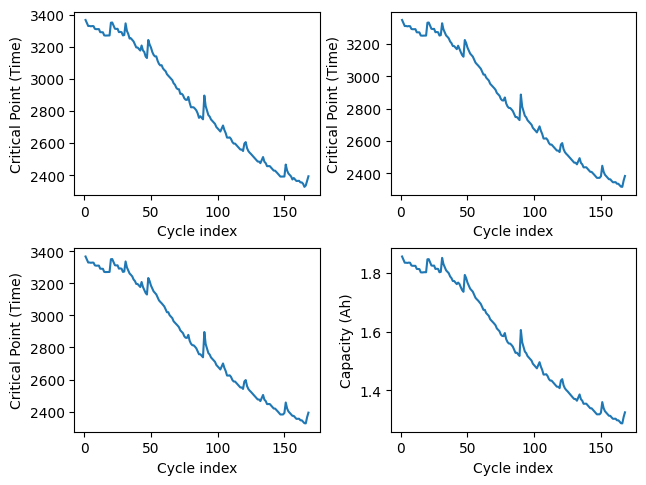

In [16]:
## Plotting (Critical Points) v/s (Cycles)

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(1, len(temperature_measured) + 1), temperature_measured)
axs[0, 0].set(ylabel = "Critical Point (Time)", xlabel = 'Cycle index')

axs[0, 1].plot(range(1, len(voltage_measured) + 1), voltage_measured)
axs[0, 1].set(ylabel = 'Critical Point (Time)', xlabel = 'Cycle index')

axs[1, 0].plot(range(1, len(voltage_load) + 1), voltage_load)
axs[1, 0].set(ylabel = 'Critical Point (Time)', xlabel = 'Cycle index')

axs[1, 1].plot(range(1, len(voltage_measured) + 1), capacity)
axs[1, 1].set(ylabel = 'Capacity (Ah)', xlabel = 'Cycle index')

fig.tight_layout(pad = 0.5)

## Linear Regression

In [17]:
#We are using Battery 005, 006 and 007
temperature_measured = []
voltage_measured = []
voltage_load = []
capacity = []

#Cycles is a dictionary with necessary data
for b in bs:
    if 'Capacity' in Cycles[b]:
        for c in Cycles[b]['Capacity']:
            capacity.append(c)

for battery in bs:
    # Find the minimum length among all relevant lists to avoid out-of-range errors
    min_length = min(len(Cycles[battery].get('Temperature_measured', [])),
                     len(Cycles[battery].get('Time', [])),
                     len(Cycles[battery].get('Voltage_measured', [])),
                     len(Cycles[battery].get('Voltage_load', [])))

    for i in range(min_length):
        try:
            temp_meas = Cycles[battery]['Temperature_measured'][i]
            time_meas = Cycles[battery]['Time'][i]
            voltage_meas = Cycles[battery]['Voltage_measured'][i]
            voltage_load_meas = Cycles[battery]['Voltage_load'][i]

            temperature_measured.append(getTemperatureMeasuredCritical(temp_meas, time_meas))
            voltage_measured.append(getVoltageMeasuredCritical(voltage_meas, time_meas))
            voltage_load.append(getVoltageLoadCritical(voltage_load_meas, time_meas))
        except IndexError as e:
            print(f"IndexError for battery {battery}, cycle {i}: {e}")
        except KeyError as e:
            print(f"KeyError for battery {battery}, cycle {i}: {e}")

# Print the lengths of the collected data for verification
print(f"Length of temperature_measured: {len(temperature_measured)}")
print(f"Length of voltage_measured: {len(voltage_measured)}")
print(f"Length of voltage_load: {len(voltage_load)}")
print(f"Length of capacity: {len(capacity)}")

Length of temperature_measured: 636
Length of voltage_measured: 636
Length of voltage_load: 636
Length of capacity: 636


**Training the Model**

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
X = []
for i in range(len(temperature_measured)):
    X.append(np.array([temperature_measured[i], voltage_measured[i], voltage_load[i]]))
X = np.array(X)
y = np.array(capacity)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [23]:
y_pred = regressor.predict(X_test)
diff = 0
total = 0
for i in range(len(y_test)):
    diff += abs(y_test[i] - y_pred[i])
    total += y_test[i]
diff /= len(y_test)
total /= len(y_test)
accuracy = ((total - diff) / total) * 100
print(f'Average Difference Between Predicted and Real Capacities: {diff}')
print(f'Accuracy: {accuracy}')

Average Difference Between Predicted and Real Capacities: 0.01118529817399774
Accuracy: 99.29725832296832


## Conclusion
* Using Dataset from 3 batteries 005, 006 and 007
* A new dataset was fromed by mixing cycles from this batteries
* Linear Regression yielded an accuracy of 99.29